In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplleaflet
%matplotlib inline

In [2]:
subway = pd.read_csv('spring_2017.csv', usecols=[1,2,3,4,5,6,7,8])

In [3]:
subway['datetime'] = pd.to_datetime(subway['datetime'])
subway['weekday'] = subway['datetime'].dt.weekday
subway['weekday2'] = subway['datetime'].dt.weekday_name

In [4]:
subway['date'] = subway['datetime'].dt.date

In [5]:
#subway.info()

In [6]:
#subway.groupby(['c/a','unit','scp','station']).mean() this gave 4716 rows, which is the number of individual turnstiles.

In [7]:
subway.dropna(inplace = True) #This drops about 25000 rows out of 1.18 million, about 2$

In [8]:
#subway.head()

In [9]:
#subway.iloc[-1]['datetime'] - subway.iloc[0]['datetime']

In [10]:
#subway['daily'] = subway.groupby(['station','weekday'])[['hr4']].sum()

In [11]:
subway['station_line'] = subway['station']+ ' ' + subway['linename']

In [12]:
#subway[subway['station_line'].str.contains('161')]

In [13]:
weeklylargest = (subway
                 .groupby(['station_line','weekday', 'weekday2'],as_index=False)[['hr4']]
                 .sum()
                )
weeklylargest['hr4'] = weeklylargest['hr4']/6 #divide by 6 because we are using 6 weeks of data

In [14]:
top100=(weeklylargest
 .sort_values(['hr4'], ascending=(False))
 .head(100)
 .sort_values(['weekday', 'hr4'], ascending=(True,False))
)

In [15]:
#top100.to_csv('combined_spring_data.csv')

In [16]:
#top100[top100['station_line'].str.contains('23 ST')]

In [17]:
#top100[top100['station_line'].str.contains('3 AV-149')] #shows up in top 300

In [18]:
#top100.head(50)

f, ax = plt.subplots(figsize=(10,6))
sns.despine(left=True, bottom=True)
ax = sns.barplot(largest_plot['monthly_traffic'], largest_plot['station'])
ax.set(
    ylabel="NYC Subway Station",
    xlabel="Monthly Traffic", 
    title = "Monthly Traffic at 10 Busiest NYC Subway Stations"
    )
plt.show()

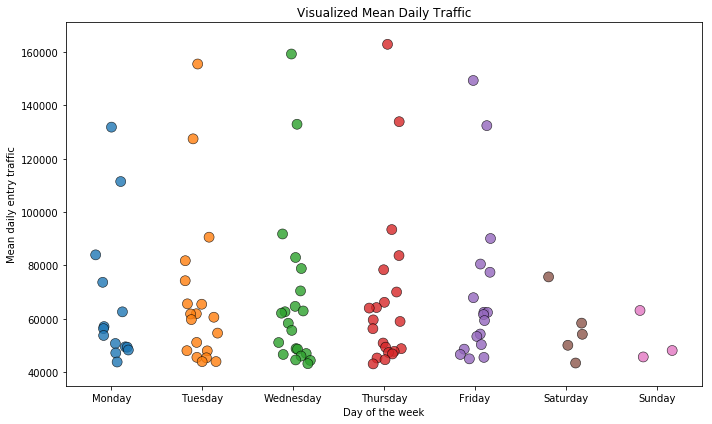

In [20]:
# Create graphic of visualized mean daily traffic

f,ax = plt.subplots(figsize=(10,6))
ax = sns.stripplot(x = 'weekday2', y='hr4', data=top100, jitter = .2, size=10, alpha=.8, linewidth=.6, edgecolor='black')
ax.set(
    ylabel="Mean daily entry traffic",
    xlabel="Day of the week",
    title = "Visualized Mean Daily Traffic")
plt.tight_layout()
#uncomment to savefig
#plt.savefig('mean_daily_traffic.png')
plt.show;

In [21]:
daily_subway = subway.groupby(['station_line','weekday'])[['hr4']].sum()

In [22]:
daily_subway.head()

hr4
station_line weekday          
1 AV L       0        101694.0
             1        128493.0
             2        137512.0
             3        141597.0
             4        141600.0

In [23]:
daily_subway = daily_subway.reset_index()

In [24]:
def is_weekday(row):
    if row < 5:
        return 1
    else: 
        return 0

In [25]:
daily_subway['is_weekday'] = daily_subway['weekday'].apply(is_weekday)

In [26]:
daily_subway = daily_subway.groupby(['station_line','is_weekday'])[['hr4']].sum().reset_index()

In [27]:
daily_subway['idx'] = daily_subway['hr4']/daily_subway['hr4'].shift(1)
daily_subway['idx_shifted'] = daily_subway['idx'].shift(-1)
daily_subway['monthly_traffic'] = daily_subway['hr4'] + daily_subway['hr4'].shift(1)
daily_subway['monthly_traffic_shifted'] = daily_subway['monthly_traffic'].shift(-1)

In [28]:
def fix_traffic(row):
    a = row.monthly_traffic
    b = row.monthly_traffic_shifted
    c = row.is_weekday
    if (c==0):
        return b
    else:
        return a

In [29]:
def fix_idx(row):
    a = row.idx
    b = row.idx_shifted
    c = row.is_weekday
    if (c==0):
        return b
    else:
        return a

In [30]:
daily_subway['monthly_traffic'] = daily_subway.apply(fix_traffic, axis=1)
daily_subway['idx'] = daily_subway.apply(fix_idx, axis=1)

In [31]:
daily_subway.drop(['monthly_traffic_shifted', 'idx_shifted'], axis=1, inplace=True)

In [32]:
daily_largest = daily_subway.groupby(['station_line','is_weekday'])[['monthly_traffic', 'idx']].sum().reset_index()

In [33]:
daily_largest = daily_largest[daily_largest.is_weekday == 1]

In [34]:
#View 10 largest stations sorted by idx
#daily_largest.nlargest(10, 'idx')

In [35]:
daily_largest = daily_largest.reset_index()

In [36]:
#daily_largest['idx'].nlargest()

In [37]:
#daily_largest.nlargest(10,'monthly_traffic')

In [38]:
daily_largest['monthly_traffic_corrected'] = (daily_largest['monthly_traffic']*.75)

In [39]:
largest_plot = daily_largest.nlargest(10,'monthly_traffic')[['station_line','monthly_traffic']]

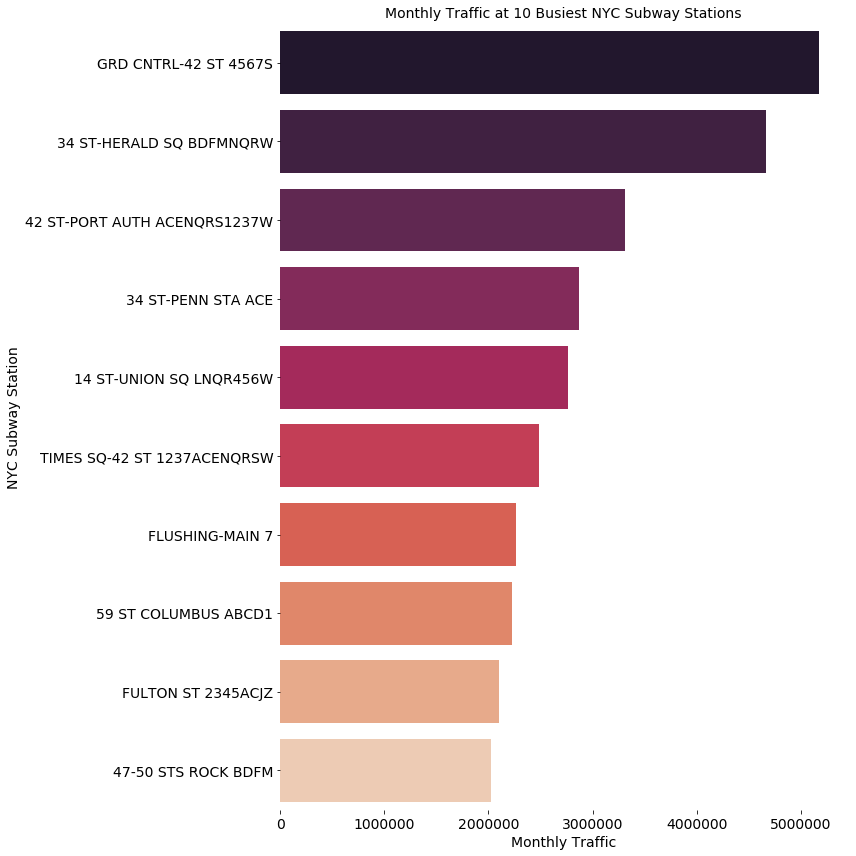

In [40]:
#create graphic of 10 busiest station
f, ax = plt.subplots(figsize=(12, 12))
sns.despine(left=True, bottom=True)
ax = sns.barplot(largest_plot['monthly_traffic'], largest_plot['station_line'], palette='rocket')
ax.set(
    ylabel="NYC Subway Station",
    xlabel="Monthly Traffic", 
    title = "Monthly Traffic at 10 Busiest NYC Subway Stations"
    )

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
    
plt.tight_layout()
#uncomment below to save the graphic
#plt.savefig('monthly_traffic_top_10.png', dpi=300)
plt.show()


In [41]:
#create map of 10 busiest stations plotted.

In [42]:
df_10busy = pd.read_csv('busiest_10_subway.csv', names=['station', 'latlong'])

In [43]:
df_10busy = df_10busy.dropna()

In [44]:
df_10busy['long'] = df_10busy['latlong'].apply(lambda x:float(x.split(' ')[1][1:]))

In [45]:
df_10busy['lat'] = df_10busy['latlong'].apply(lambda x:float(x.split(' ')[2][:-1]))

In [46]:
df_10busy.drop(['latlong'], axis=1, inplace = True)

In [47]:
df2 = daily_largest['monthly_traffic'].nlargest(10)
df2 = df2/8000 #arbitrary scaling number
df_10busy = df_10busy.assign(traffic=pd.Series(df2).values)

In [48]:
#create the interactive map
plt.scatter(x= df_10busy['long'], y= df_10busy['lat'], s=df_10busy['traffic'], color='red', edgecolors='black')
mplleaflet.show(tiles='esri_natgeo')

In [49]:
#Sakura Dataset

In [50]:
df_topstation = pd.read_csv('top_station_latlong.csv', names=['station', 'lines', 'freq', 'latlong'])

In [51]:
df_topstation = df_topstation.dropna()

In [52]:
df_topstation['long'] = df_topstation['latlong'].apply(lambda x:float(x.split(' ')[1][1:]))

In [53]:
df_topstation['lat'] = df_topstation['latlong'].apply(lambda x:float(x.split(' ')[2][:-1]))

In [54]:
df_topstation.drop(['latlong'], axis=1, inplace = True)

In [55]:
df_topstation.drop([4, 7, 9, 14, 19], inplace = True)

In [56]:
df_topstation['freq'] = df_topstation['freq']*75 #scale freq to ensure dots are appropriate size relative to each other

In [57]:
#create the interactive map
plt.scatter(x= df_topstation['long'], y= df_topstation['lat'], s=df_topstation['freq'], color='red', edgecolors='black')
mplleaflet.show(tiles='esri_natgeo')

In [58]:
#Final Recomendations dataset

In [59]:
df_final = pd.read_csv('final_recommendations.csv', names=['station','latlong', 'freq'])

In [60]:
df_final = df_final.dropna()

In [61]:
df_final['long'] = df_final['latlong'].apply(lambda x:float(x.split(' ')[1][1:]))

In [62]:
df_final['lat'] = df_final['latlong'].apply(lambda x:float(x.split(' ')[2][:-1]))

In [63]:
df_final.drop(['latlong'], axis=1, inplace = True)

In [64]:
df_final['freq'] = df_final['freq']*2.7 #Scale frequency to make dots an appropriate size on final map.

In [65]:
#create the interactive map
plt.scatter(x= df_final['long'], y= df_final['lat'], s=df_final['freq'], color='red', edgecolors='black')
mplleaflet.show(tiles='esri_natgeo')